In [1]:
# MO444-A 2s/2017 - First assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

# Plotting inline instead of opening an outer window.
%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import sqrt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Defines
years = range(1922, 2011)

# Functions
def load_data(filename):
    raw_data = open(filename, 'rt')
    data = np.loadtxt(raw_data, delimiter=",")
    return data

def split_Y_X(dataset):
    Y = dataset[:,0]
    X = dataset[:,1:]
    return Y, X

def get_errors_by_year(model, data_Y, data_X):
    errors = []
    for y in years:
        filt = data_Y == y
        if not sum(filt):
            errors.append(0)
            continue
        errors.append(mean_squared_error(data_Y[filt], model.predict(data_X[filt])))
    return errors

In [2]:
# load training data
data = load_data('year-prediction-msd-train.txt')

print('Training data size: {}'.format(len(data)))

Training data size: 463715


In [3]:
# Take a look at the data (5 first instances):
# - first column (index 0) is the song release year
# - remaining columns are the the features (indexes 1 - 90)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2004,46.50128,-18.37096,58.89824,27.28181,1.93097,-2.43167,18.64843,-5.62769,-1.47711,...,43.94716,-64.21148,13.04284,156.03785,-2.42670,51.71977,-43.56703,10.63735,24.08962,-21.41886
1,2005,41.46015,-52.30140,-4.59825,-19.28084,-11.85844,-19.54192,1.30306,-1.83185,5.98469,...,-13.48435,-154.65715,35.22429,89.53649,-3.13145,-128.28120,89.97277,-15.88139,-75.21074,-0.51139
2,2009,42.18667,-85.65863,-7.91506,-11.84193,-12.61959,-21.66749,4.97883,-11.86750,9.87342,...,42.08584,-181.77349,43.00181,87.94977,-13.70362,136.49979,140.32633,11.51422,382.79589,29.98269
3,1987,46.90244,19.86314,10.92119,4.87136,-41.17499,-19.84156,2.93308,-5.98711,3.05997,...,-2.76407,-20.31782,-75.24506,125.81801,-15.50828,-63.31002,-142.21937,-12.36699,32.45911,-17.14909
4,2009,46.64388,-81.99503,41.62851,3.65855,-9.38201,-13.51749,7.48781,-7.03302,7.06982,...,12.29244,-143.25348,91.15842,-227.85481,7.75916,-41.32376,-225.66526,-4.05081,455.39458,41.65310


In [4]:
# split train data into training/validation (80/20)
train_data, validation_data = train_test_split(data, test_size=0.2)

print('Train data size: {}'.format(len(train_data)))
print('Validation data size: {}'.format(len(validation_data)))

Train data size: 370972
Validation data size: 92743


In [5]:
# load test data
test_data = load_data('year-prediction-msd-test.txt')

print('Test data size: {}'.format(len(test_data)))

Test data size: 36285


In [6]:
# Split label (years) and features
train_data_Y, train_data_X = split_Y_X(train_data)
validation_data_Y, validation_data_X = split_Y_X(validation_data)
test_data_Y, test_data_X = split_Y_X(test_data)

In [28]:
# Create a baseline linear regression model and train it
lr_base_model = LinearRegression(copy_X=True)
lr_base_model.fit(train_data_X, train_data_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [29]:
# print the model errors
predicted_train_data_Y = lr_base_model.predict(train_data_X)
mean_sq_error_training = mean_squared_error(train_data_Y, predicted_train_data_Y)
print('Training root mean squared error: {}'.format(sqrt(mean_sq_error_training)))
print('Training score: {}'.format(r2_score(train_data_Y, predicted_train_data_Y)))

predicted_validation_data_Y = lr_base_model.predict(validation_data_X)
mean_sq_error_validation = mean_squared_error(validation_data_Y, predicted_validation_data_Y)
print('Validation root mean squared error: {}'.format(sqrt(mean_sq_error_validation)))
print('Validation score: {}'.format(r2_score(validation_data_Y, predicted_validation_data_Y)))

Training root mean squared error: 9.56679072339
Training score: 0.23698556791
Validation root mean squared error: 9.49784010891
Validation score: 0.239331553324


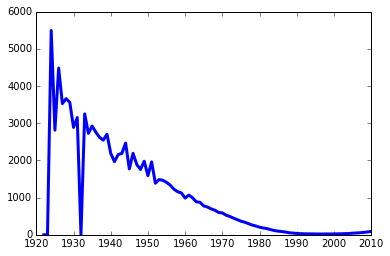

In [10]:
# plotting the errors
errors = get_errors_by_year(lr_base_model, validation_data_Y, validation_data_X)
plt.plot(years, errors, color='blue', linewidth=3)
plt.show()

In [21]:
# LR-based alternative #1: LR with Stochastic Gradient Descent
lr_sgd_model = SGDRegressor(loss='squared_loss', penalty=None)

# normalize the data before fitting
lr_sgd_scaler = preprocessing.StandardScaler()

lr_sgd_model.fit(lr_sgd_scaler.fit_transform(train_data_X), train_data_Y )

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5, n_iter=None, penalty=None,
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [22]:
# Check the model errors
predicted_train_data_Y = lr_sgd_model.predict(lr_sgd_scaler.transform(train_data_X))
mean_sq_error_training = mean_squared_error(train_data_Y, predicted_train_data_Y)
print('Training root mean squared error: {}'.format(sqrt(mean_sq_error_training)))
print('Training score: {}'.format(r2_score(train_data_Y, predicted_train_data_Y)))

predicted_validation_data_Y = lr_sgd_model.predict(lr_sgd_scaler.transform(validation_data_X))
mean_sq_error_validation = mean_squared_error(validation_data_Y, predicted_validation_data_Y)
print('Validation root mean squared error: {}'.format(sqrt(mean_sq_error_validation)))
print('Validation score: {}'.format(r2_score(validation_data_Y, predicted_validation_data_Y)))

Training root mean squared error: 9.64283139679
Training score: 0.224807876039
Validation root mean squared error: 9.5759361698
Validation score: 0.226770920899


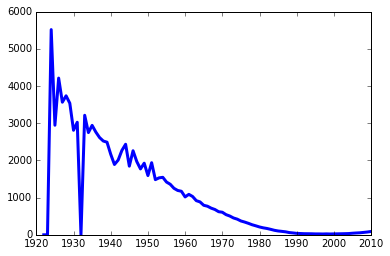

In [23]:
# Plotting the errors:
errors = get_errors_by_year(lr_sgd_model, validation_data_Y, lr_sgd_scaler.transform(validation_data_X))
plt.plot(years, errors, color='blue', linewidth=3)
plt.show()

In [26]:
# LR-based alternative #2: Mini-batch Gradient Descent
lr_mbgd_model = SGDRegressor(loss='squared_loss', penalty=None)

# normalize the data before fitting
lr_mbgd_scaler = preprocessing.StandardScaler()
trans_train_data_X = lr_mbgd_scaler.fit_transform(train_data_X)

# feed the data partially
n_chunks = 10
chunk_size = len(train_data_Y) / n_chunks
for i in range(0, n_chunks):
    range_start = i * chunk_size
    range_end = (i + 1) * chunk_size
    lr_mbgd_model.partial_fit(trans_train_data_X[range_start:range_end], train_data_Y[range_start:range_end])    

In [27]:
# Check the model errors
predicted_train_data_Y = lr_mbgd_model.predict(lr_mbgd_scaler.transform(train_data_X))
mean_sq_error_training = mean_squared_error(train_data_Y, predicted_train_data_Y)
print('Training root mean squared error: {}'.format(sqrt(mean_sq_error_training)))
print('Training score: {}'.format(r2_score(train_data_Y, predicted_train_data_Y)))

predicted_validation_data_Y = lr_mbgd_model.predict(lr_mbgd_scaler.transform(validation_data_X))
mean_sq_error_validation = mean_squared_error(validation_data_Y, predicted_validation_data_Y)
print('Validation root mean squared error: {}'.format(sqrt(mean_sq_error_validation)))
print('Validation score: {}'.format(r2_score(validation_data_Y, predicted_validation_data_Y)))

Training root mean squared error: 9.65581657514
Training score: 0.222718700133
Validation root mean squared error: 9.58467084323
Validation score: 0.225359678457


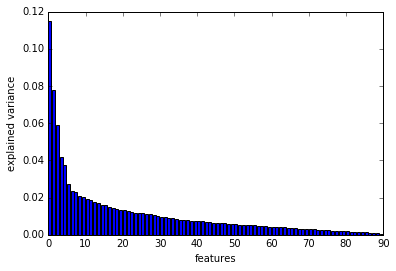

[ 0.11511782  0.07797391  0.05913601  0.04207973  0.03746342  0.02757902
  0.02367796  0.02319794  0.02092266  0.02020299  0.01918482  0.01860773
  0.01786656  0.01689058  0.01614853  0.01586826  0.01520548  0.01423138
  0.01403678  0.01351414  0.01311276  0.01256435  0.01234064  0.01183731
  0.01156073  0.01145684  0.01103542  0.01095685  0.01041229  0.01006665
  0.00981842  0.00943565  0.00926305  0.00894771  0.00840744  0.008182
  0.00805066  0.008012    0.00760168  0.00745797  0.00732907  0.00716555
  0.00698398  0.00681637  0.00659939  0.00634251  0.00625089  0.00614923
  0.00599124  0.00585477  0.00570149  0.00551383  0.00535858  0.00517812
  0.00501981  0.00500876  0.0048669   0.00472594  0.00461687  0.00438974
  0.00424538  0.00410695  0.00395797  0.00393129  0.00372678  0.00363943
  0.00349594  0.00337456  0.00326502  0.00317368  0.00304241  0.00294689
  0.00276326  0.00275294  0.00261549  0.00248291  0.0022899   0.00214909
  0.00209622  0.00205013  0.00188474  0.00175797  0.0

In [14]:
# LR-based alternative #3: Feature reduction

# Principal component analysis (PCA)
pca = PCA(n_components=90).fit(scaler.fit_transform(train_data_X))
plt.bar(range(0, 90), pca.explained_variance_ratio_)
plt.xlabel('features')
plt.ylabel('explained variance')
plt.show()
print(pca.explained_variance_ratio_)

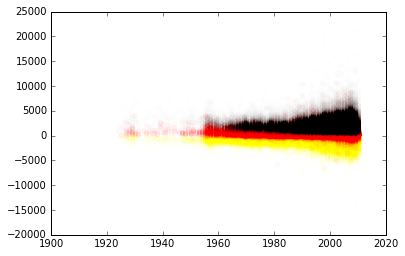

In [15]:
# First three PCA components plotted
transformed_data = pca.transform(validation_data_X)
plt.scatter(validation_data_Y, transformed_data[:,2], color='yellow', alpha=0.02)
plt.scatter(validation_data_Y, transformed_data[:,1], color='red', alpha=0.02)
plt.scatter(validation_data_Y, transformed_data[:,0], color='black', alpha=0.005)
plt.show()

In [16]:
for n_components in range(0, 91, 10):
    n_components = n_components or 1
    transformed_train_data_X = pca.transform(train_data_X)[:,range(0, n_components)]

    lr_pca_model = LinearRegression(copy_X=True)
    lr_pca_model.fit(transformed_train_data_X, train_data_Y)

    mean_sq_error_training = mean_squared_error(train_data_Y, lr_pca_model.predict(transformed_train_data_X))
    
    transformed_validation_data_X = pca.transform(validation_data_X)[:,range(0, n_components)]
    mean_sq_error_validation = mean_squared_error(validation_data_Y, lr_pca_model.predict(transformed_validation_data_X))

    print '%2d PCA components used: %5.2f %5.2f' % (n_components, sqrt(mean_sq_error_training), sqrt(mean_sq_error_validation))


 1 PCA components used: 10.95 10.89
10 PCA components used: 10.67 10.61
20 PCA components used: 10.59 10.53
30 PCA components used: 10.46 10.39
40 PCA components used: 10.41 10.35
50 PCA components used: 10.31 10.24
60 PCA components used: 10.25 10.19
70 PCA components used: 10.21 10.16
80 PCA components used:  9.97  9.91
90 PCA components used:  9.57  9.50


In [17]:
# performs ridge regression for 1 to 4 degrees
n_components = 7
for degree in range(1, 5):
    transformed_train_data_X = pca.transform(train_data_X)[:,range(0, n_components)]
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    # model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(transformed_train_data_X, train_data_Y)
    
    mean_sq_error_training = mean_squared_error(train_data_Y, model.predict(transformed_train_data_X))
    
    transformed_validation_data_X = pca.transform(validation_data_X)[:,range(0, n_components)]
    mean_sq_error_validation = mean_squared_error(validation_data_Y, model.predict(transformed_validation_data_X))

    print '%d degrees: %5.2f %5.2f' % (degree, sqrt(mean_sq_error_training), sqrt(mean_sq_error_validation))

1 degrees: 10.70 10.63
2 degrees: 10.62 10.56
3 degrees: 10.56 10.52
4 degrees: 10.51 10.61
